# cgl1 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import cgl1 as c1
from lib.functions import g1

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
                      get_period, bif1d, follow_phase_diffs, _get_sol,
                      get_phase_diff_f_v2, get_period_all)

from generate_figures import _full_cgl1, draw_forcing_sols

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined,
                           add_diagram_full, add_diagram_1d,
                           load_diagram_full_f)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
kws1 = {'var_names':['x','y'],
       'init':np.array([1,0,2*np.pi]),
       'TN':2000,
       'idx':0,
       'model_name':'cglf0',
       'trunc_order':1,
       'recompute_list':[],
       'g_forward':False,
       'z_forward':False,
       'i_forward':[False,True,True,True,True,True,True],
       'i_bad_dx':[False,True,False,False,False,False,False],
       'max_iter':20,
       'rtol':1e-12,
       'atol':1e-12,
       'rel_tol':1e-9,
       'forcing_fn':g1,
       'rhs':c1.rhs_old2}

In [4]:
pd_cgl_template = {'sig':.08,'rho':.12,'mu':1,'om':1,'om_fix':1}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-10,'atol':1e-10}

In [6]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(**{'pardict':pd_cgl_template,**kws1})

mkdir ./data/cglf0/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999999999994668
* Loading monodromy...
* Floquet Exponent kappa =-0.16000000000084508
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# 1:1

In [9]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

## del=0.01

In [10]:
del11_p01 = 0.01
a11_p01 = nm.nmCoupling(**kw_nm, del1=del11_p01)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

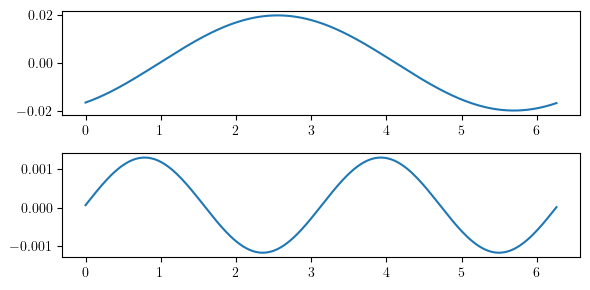

In [11]:
aa = a11_p01
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

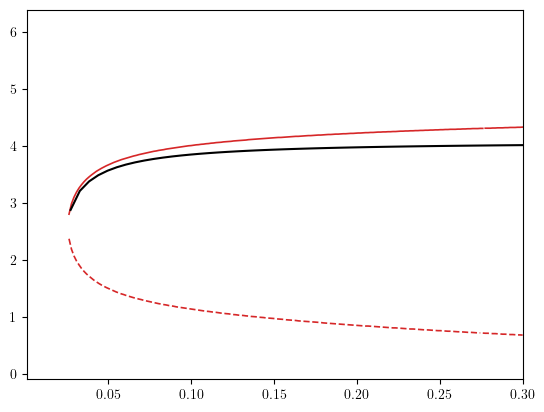

In [12]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a11_p01,del11_p01,(.001,.3,200),rhs=rhs_avg_1df)

etup = (.0275,.3,50)
bif11a = load_diagram_full_f(a11_p01,del11_p01,eps_tup=etup,dir1='bifdat2',
                            rhs=_full_cgl1,phi0=np.pi,recompute=False)
bif11a = np.array(bif11a)
axs.plot(np.linspace(*etup),bif11a,color='k')


### Sims

In [13]:
# coupling and init
eps11_p01 = 0.2
th_init11_p01 = 2

In [14]:
# sim params
dt = .01;T_p01=1000
t11_p01 = np.arange(0,T_p01,dt)
args11_p01 = {'args':(a11_p01,eps11_p01,del11_p01),
             't_eval':t11_p01,**kw_sim,'dense_output':True}

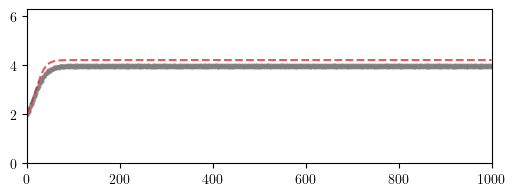

In [15]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

y0_p01 = a11_p01.system1.lc['dat'][int((th_init11_p01/(2*np.pi))*a11_p01.system1.TN),:]
args0 = [a11_p01,eps11_p01,del11_p01]

solf = _get_sol(_full_cgl1,y0_p01,t11_p01,args=args0,recompute=True)        
tp,fp = get_phase(t11_p01,solf,skipn=100,system1=a11_p01.system1)
force_phase = (a11_p01._m[1]+del11_p01)*tp
fp2 = np.mod(fp-a11_p01.om*force_phase,2*np.pi)

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p01)

args1 = {'t_eval':t11_p01,'t_span':[0,t11_p01[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init11_p01],**args1)

# 1d solution over time
axs.plot(t11_p01,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',
         alpha=.75,label='1D',ls='--')

# xs = np.mod(solr1d.y.T[:,0],2*np.pi); ys = np.zeros(len(xs))
# discont_idxs = np.abs(np.gradient(xs,1)) > np.pi/2

# xs[discont_idxs] = np.nan; ys[discont_idxs] = np.nan

## del=0.04

In [16]:
del11_p04 = 0.04
a11_p04 = nm.nmCoupling(**kw_nm, del1=del11_p04)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

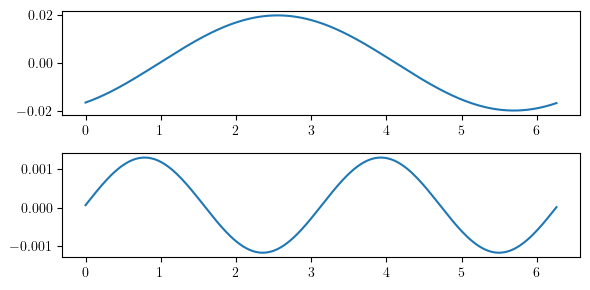

In [17]:
aa = a11_p04
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

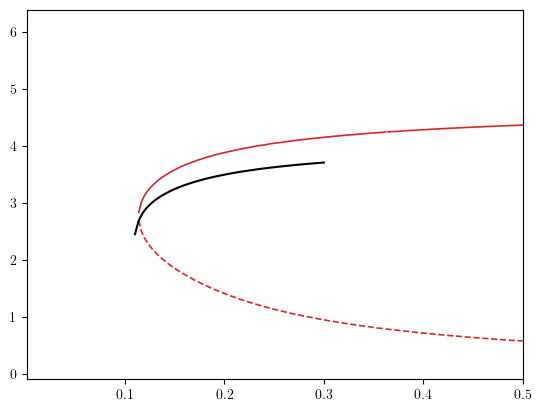

In [18]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a11_p04,del11_p04,(.001,.5,200),rhs=rhs_avg_1df)
etup = (.11,.3,51)
bif11b = load_diagram_full_f(a11_p04,del11_p04,eps_tup=etup,dir1='bifdat2',
                            rhs=_full_cgl1,phi0=np.pi,recompute=False)
bif11b = np.array(bif11b)
axs.plot(np.linspace(*etup),bif11b,color='k')

# 2:1

In [19]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

## del=0.01

In [20]:
del21_p01 = 0.01
a21_p01 = nm.nmCoupling(**kw_nm, del1=del21_p01)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

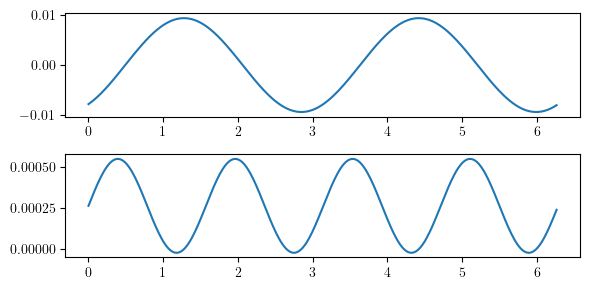

In [21]:
aa = a21_p01
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

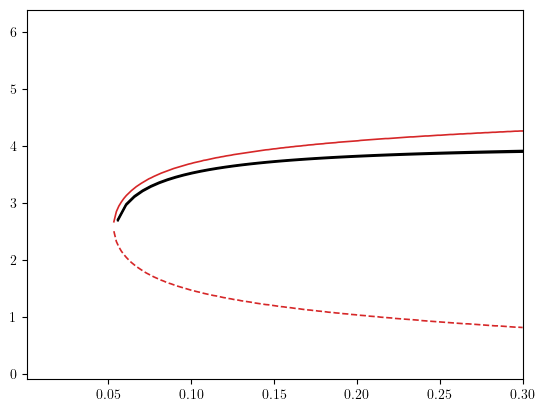

In [22]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a21_p01,del21_p01,(.001,.3,200),rhs=rhs_avg_1df)

etup = (.056,.3,50)
test = load_diagram_full_f(a21_p01,del21_p01,eps_tup=etup,dir1='bifdat2',
                           rhs=_full_cgl1,phi0=np.pi)
test = np.array(test)
axs.plot(np.linspace(*etup),test[:,0],color='k')
axs.plot(np.linspace(*etup),test[:,1],color='k')

#add_diagram_full(axs,a21_p01,del21_p01,(.056,.5,100),rhs=_full_cgl1)

### Sims

In [23]:
# coupling and init
eps21_p01 = 0.2
th_init21_p01 = 2

In [24]:
# sim params
dt = .01;T_p01=1000
t21_p01 = np.arange(0,T_p01,dt)
args21_p01 = {'args':(a21_p01,eps21_p01,del21_p01),
             't_eval':t21_p01,**kw_sim,'dense_output':True}

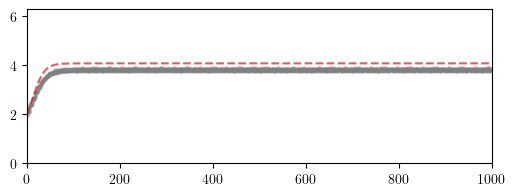

In [25]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

y0_p01 = a21_p01.system1.lc['dat'][int((th_init21_p01/(2*np.pi))*a21_p01.system1.TN),:]
args0 = [a21_p01,eps21_p01,del21_p01]

solf = _get_sol(_full_cgl1,y0_p01,t21_p01,args=args0,recompute=True)        
tp,fp = get_phase(t21_p01,solf,skipn=100,system1=a21_p01.system1)
force_phase = (a21_p01._m[1]+del21_p01)*tp
fp2 = np.mod(fp-a21_p01.om*force_phase,2*np.pi)

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p01)

args1 = {'t_eval':t21_p01,'t_span':[0,t21_p01[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init21_p01],**args1)

# 1d solution over time
axs.plot(t21_p01,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',
         alpha=.75,label='1D',ls='--')

# xs = np.mod(solr1d.y.T[:,0],2*np.pi); ys = np.zeros(len(xs))
# discont_idxs = np.abs(np.gradient(xs,1)) > np.pi/2

# xs[discont_idxs] = np.nan; ys[discont_idxs] = np.nan

## del=0.025

In [26]:
del21_p025 = 0.025
a21_p025 = nm.nmCoupling(**kw_nm, del1=del21_p025)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

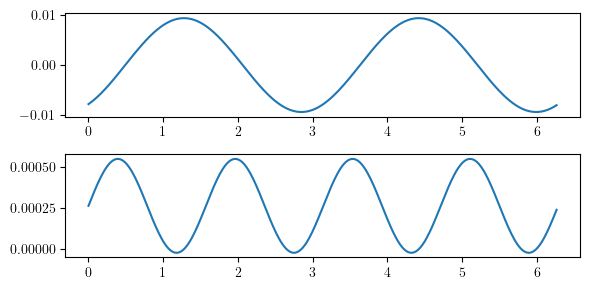

In [27]:
aa = a21_p025
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

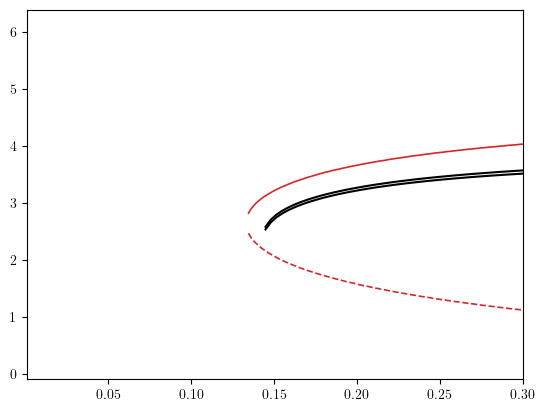

In [28]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a21_p025,del21_p025,(.001,.3,200),rhs=rhs_avg_1df)
etup = (.145,.3,50)
bif21b = load_diagram_full_f(a21_p025,del21_p025,eps_tup=etup,dir1='bifdat2',
                             rhs=_full_cgl1,phi0=np.pi,recompute=False)
bif21b = np.array(bif21b)
axs.plot(np.linspace(*etup),bif21b,color='k')

# 3:1

In [29]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',3),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

## del=0.01

In [30]:
del31_p001 = 0.001
a31_p001 = nm.nmCoupling(**kw_nm, del1=del31_p001)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

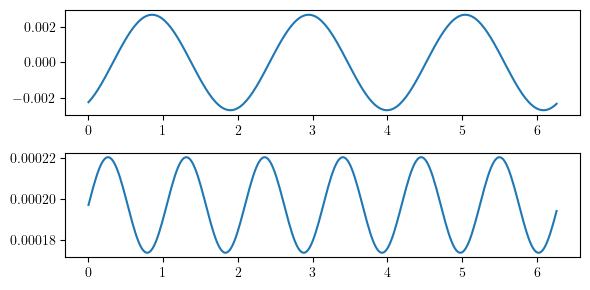

In [31]:
aa = a31_p001
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

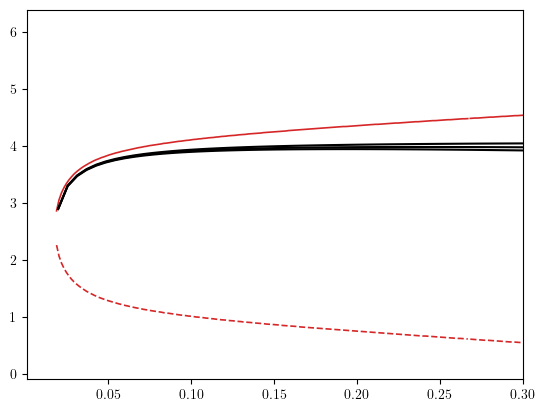

In [32]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a31_p001,del31_p001,(.001,.3,200),rhs=rhs_avg_1df)
etup = (.02,.3,50)
bif31a = load_diagram_full_f(a31_p001,del31_p001,eps_tup=etup,dir1='bifdat2',
                            rhs=_full_cgl1,phi0=np.pi,recompute=False)
bif31a = np.array(bif31a)
axs.plot(np.linspace(*etup),bif31a,color='k')

### Aside

Try taking a look at neighboring parameter sims to see where this discrepancy is coming from

In [33]:
# coupling and init
etemp1 = 0.5;etemp2 = 0.4951515151515152
init_temp1 = 2

# sim params
ttemp = np.arange(0,1000,.01)
argstemp1 = {'args':(a31_p001,etemp1,del31_p001),
             't_eval':ttemp,**kw_sim,'dense_output':True}

y0_temp1 = a31_p001.system1.lc['dat'][int((init_temp1/(2*np.pi))*a31_p001.system1.TN),:]
args_temp1 = [a31_p001,etemp1,del31_p001]
args_temp2 = [a31_p001,etemp2,del31_p001]

solf_temp1 = _get_sol(_full_cgl1,y0_temp1,ttemp,args=args_temp1,recompute=True)  
solf_temp2 = _get_sol(_full_cgl1,y0_temp1,ttemp,args=args_temp2,recompute=True)  

(979.99, 999.99)

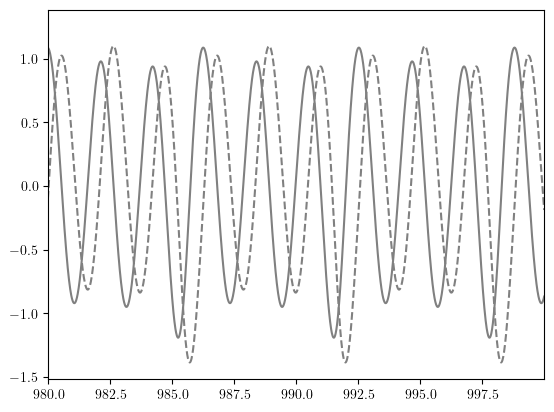

In [34]:
fig,axs = plt.subplots()
axs.plot(ttemp,solf_temp1[:,0],color='gray')
axs.plot(ttemp,solf_temp1[:,1],color='gray',ls='--')

#axs.plot(ttemp,solf_temp2[:,0],color='red')
#axs.plot(ttemp,solf_temp2[:,1],color='red',ls='--')

axs.set_xlim(ttemp[-1]-20,ttemp[-1])

### Sims

In [35]:
# coupling and init
eps31_p001 = 0.2
th_init31_p001 = 2

In [36]:
# sim params
dt = .01;T_p01=1000
t31_p001 = np.arange(0,T_p01,dt)
args31_p001 = {'args':(a31_p001,eps31_p001,del31_p001),
             't_eval':t31_p001,**kw_sim,'dense_output':True}

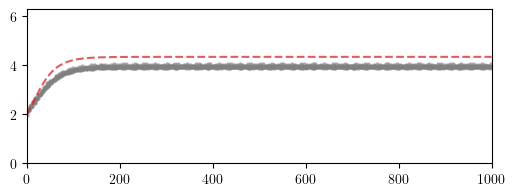

In [37]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

y0_p01 = a31_p001.system1.lc['dat'][int((th_init31_p001/(2*np.pi))*a31_p001.system1.TN),:]
args0 = [a31_p001,eps31_p001,del31_p001]

solf = _get_sol(_full_cgl1,y0_p01,t31_p001,args=args0,recompute=True)        
tp,fp = get_phase(t31_p001,solf,skipn=100,system1=a31_p001.system1)
force_phase = (a31_p001._m[1]+del31_p001)*tp
fp2 = np.mod(fp-a31_p001.om*force_phase,2*np.pi)

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p01)

args1 = {'t_eval':t31_p001,'t_span':[0,t31_p001[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init31_p001],**args1)

# 1d solution over time
axs.plot(t31_p001,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',
         alpha=.75,label='1D',ls='--')

# xs = np.mod(solr1d.y.T[:,0],2*np.pi); ys = np.zeros(len(xs))
# discont_idxs = np.abs(np.gradient(xs,1)) > np.pi/2

# xs[discont_idxs] = np.nan; ys[discont_idxs] = np.nan

## del=0.008

In [38]:
del31_p008 = 0.008
a31_p008 = nm.nmCoupling(**kw_nm, del1=del31_p008)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

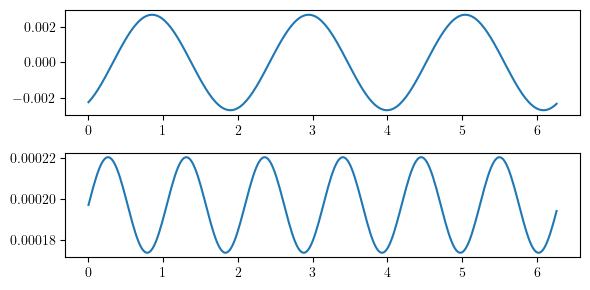

In [39]:
aa = a31_p008
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

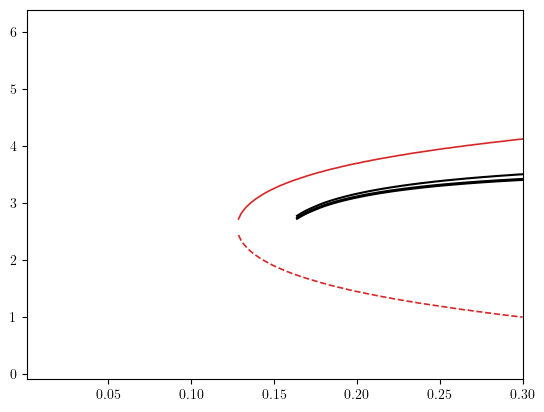

In [40]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a31_p008,del31_p008,(.001,.3,200),rhs=rhs_avg_1df)
etup = (.164,.3,50)
bif31b = load_diagram_full_f(a31_p008,del31_p008,eps_tup=etup,dir1='bifdat2',
                             rhs=_full_cgl1,phi0=np.pi,recompute=False)
bif31b = np.array(bif31b)
axs.plot(np.linspace(*etup),bif31b[:,0],color='k')
axs.plot(np.linspace(*etup),bif31b[:,2],color='k')

axs.plot(np.linspace(*etup),bif31b[:,1],color='k')

### Aside

Figure out why there's a weird disconnect in the bifurcation diagram.

Periods seem to be consistent...

In [41]:
print(bif31b[:,1][5:9])
print(np.linspace(*(.164,.5,50))[5:9])

[2.93194323 2.96166481 2.98754478 3.01188093]
[0.19828571 0.20514286 0.212      0.21885714]


In [42]:
# coupling and init
etemp1 = 0.20514286;etemp2 = 0.212
init_temp1 = 2

# sim params
y0_temp1 = a31_p008.system1.lc['dat'][int((init_temp1/(2*np.pi))*a31_p008.system1.TN),:]
args_temp1 = [a31_p008,etemp1,del31_p008]
args_temp2 = [a31_p008,etemp2,del31_p008]

# run for a while and get period
max_time = 3000
ttemp = np.arange(0,max_time,.01)
solf_temp1 = solve_ivp(_full_cgl1,[0,max_time],y0_temp1,args=args_temp1,t_eval=ttemp,**kw_bif)
solf_temp2 = solve_ivp(_full_cgl1,[0,max_time],y0_temp1,args=args_temp2,t_eval=ttemp,**kw_bif)

(2989.9900000000002, 2999.9900000000002)

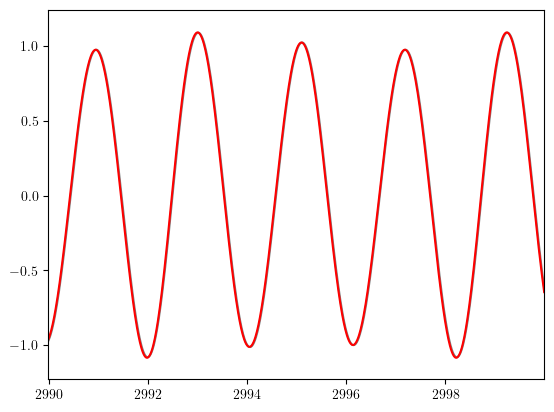

In [43]:
fig,axs = plt.subplots()
axs.plot(ttemp,solf_temp1.y.T[:,0],color='gray')
axs.plot(ttemp,solf_temp2.y.T[:,0],color='red')

#axs.plot(ttemp,solf_temp2[:,0],color='red')
#axs.plot(ttemp,solf_temp2[:,1],color='red',ls='--')

axs.set_xlim(ttemp[-1]-10,ttemp[-1])

Time series looks okay...

In [44]:
get_period_all(solf_temp1,idx=0,n=3)

[(2.0554847075077305, 2419.5499833782474),
 (2.093919568227193, 2421.6439029464746),
 (2.0839145751074284, 2423.727817521582)]

In [45]:
get_period_all(solf_temp2,idx=0,n=3)

[(2.054719756186387, 2743.6700159169463),
 (2.0947303291195567, 2745.764746246066),
 (2.0838687375257905, 2747.8486149835917)]

Period looks okay...

# 4:1

In [46]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm = {'system1':system1,'system2':None,'_n':('om0',4),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

## del=0.0001

In [47]:
del41_p002 = 0.0001
a41_p002 = nm.nmCoupling(**kw_nm, del1=del41_p002)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

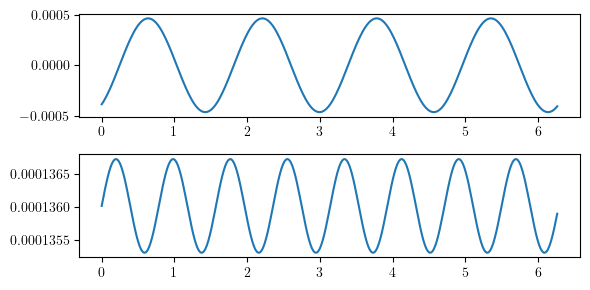

In [48]:
aa = a41_p002
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

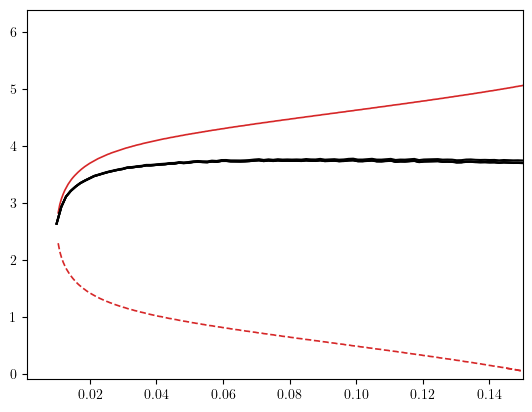

In [49]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a41_p002,del41_p002,(.001,.15,300),rhs=rhs_avg_1df)

etup = (.01,.15,100)
bif41b = load_diagram_full_f(a41_p002,del41_p002,eps_tup=etup,dir1='bifdat2',
                            rhs=_full_cgl1,phi0=np.pi,recompute=False,
                            maxt=100)
bif41b = np.array(bif41b)
axs.plot(np.linspace(*etup),bif41b,color='k')

## del=0.0007

In [52]:
del41_p0007 = 0.0007
a41_p0007 = nm.nmCoupling(**kw_nm, del1=del41_p0007)

* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


### H functions

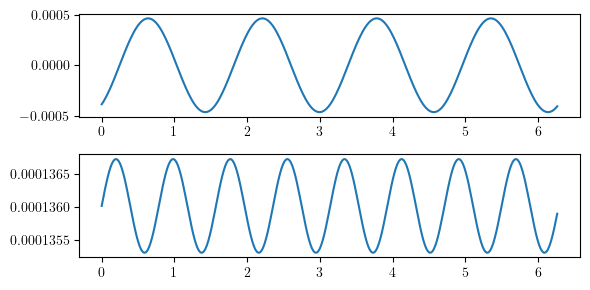

In [53]:
aa = a41_p0007
fig,axs = plt.subplots(aa.system1.miter,1,figsize=(6,3))
etemp = .05
h = 0
for k in range(aa.system1.miter):
    axs[k].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    
plt.tight_layout()

### Plot

eps= 0.075 ; Tlist= [(1.565919308479124, 1281.7902942438348), (1.5730581112936761, 1283.3633523551284), (1.5705349613310773, 1284.9338873164595), (1.5696834074544768, 1286.503570723914)]
eps= 0.078125 ; Tlist= [(1.5655662152007608, 1218.9786738170976), (1.573331884647132, 1220.5520057017447), (1.5705681715692208, 1222.122573873314), (1.5696247845473863, 1223.6921986578614)]
eps= 0.08125 ; Tlist= [(1.5652443415642665, 1156.170958409711), (1.573598269269496, 1157.7445566789804), (1.570601736112394, 1159.3151584150928), (1.5695710520105877, 1160.8847294671034)]
eps= 0.08437499999999999 ; Tlist= [(1.564948318322422, 1131.0400191851008), (1.5738511457166169, 1132.6138703308175), (1.5706321178488452, 1134.1845024486663), (1.56952153313091, 1135.7540239817972)]
eps= 0.0875 ; Tlist= [(1.5646656104079284, 1112.1898359170202), (1.57410094128727, 1113.7639368583075), (1.5706630115355438, 1115.334599869843), (1.5694740020624067, 1116.9040738719054)]
eps= 0.090625 ; Tlist= [(1.5643873366940397, 986

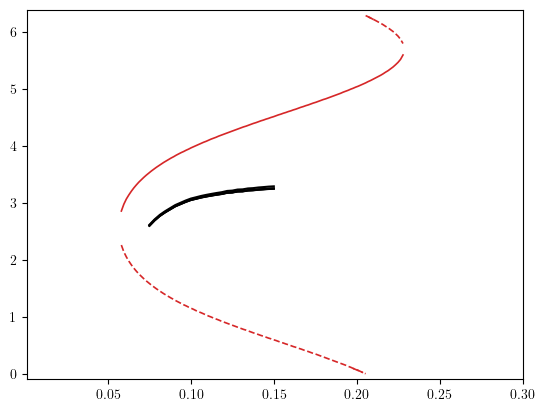

In [58]:
fig,axs = plt.subplots()

add_diagram_1d(axs,a41_p0007,del41_p0007,(.001,.3,200),rhs=rhs_avg_1df)
etup = (.075,.15,25)
bif41a = load_diagram_full_f(a41_p0007,del41_p0007,eps_tup=etup,dir1='bifdat2',
                            rhs=_full_cgl1,phi0=np.pi,recompute=False)
bif41a = np.array(bif41a)
axs.plot(np.linspace(*etup),bif41a,color='k')

### Sims

In [50]:
# coupling and init
eps41_p0007 = 0.1
th_init41_p0007 = 2

In [51]:
# sim params
dt = .01;T_p01=1000
t41_p0007 = np.arange(0,T_p01,dt)
args41_p0007 = {'args':(a41_p0007,eps41_p0007,del41_p0007),
             't_eval':t41_p0007,**kw_sim,'dense_output':True}

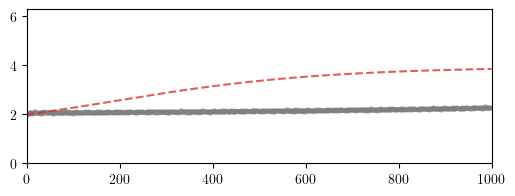

In [52]:
fig,axs = plt.subplots(1,1,figsize=(6,2))

y0_p01 = a41_p0007.system1.lc['dat'][int((th_init41_p0007/(2*np.pi))*a41_p0007.system1.TN),:]
args0 = [a41_p0007,eps41_p0007,del41_p0007]

solf = _get_sol(_full_cgl1,y0_p01,t41_p0007,args=args0,recompute=True)        
tp,fp = get_phase(t41_p0007,solf,skipn=100,system1=a41_p0007.system1)
force_phase = (a41_p0007._m[1]+del41_p0007)*tp
fp2 = np.mod(fp-a41_p0007.om*force_phase,2*np.pi)

# plot full sol
axs.scatter(tp,fp2,s=5,color='gray',alpha=.5,label='Full')
axs.set_ylim(0,2*np.pi)
axs.set_xlim(0,T_p01)

args1 = {'t_eval':t41_p0007,'t_span':[0,t41_p0007[-1]],'args':(*args0,),**kw_sim}
solr1d = solve_ivp(rhs_avg_1df,y0=[th_init41_p0007],**args1)

# 1d solution over time
axs.plot(t41_p0007,np.mod(solr1d.y.T[:,0],2*np.pi),color='tab:red',
         alpha=.75,label='1D',ls='--')

# xs = np.mod(solr1d.y.T[:,0],2*np.pi); ys = np.zeros(len(xs))
# discont_idxs = np.abs(np.gradient(xs,1)) > np.pi/2

# xs[discont_idxs] = np.nan; ys[discont_idxs] = np.nan